In [1]:
import os
import sys; sys.path.append("~/HHbbgg_ETH/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)

Welcome to ROOTaaS 6.06/05


<module 'training_utils' from '/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/Training/python/training_utils.pyc'>

In [2]:
ntuples = '20170509'
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
signal = [s for s in files if "NonRes" in s]
background = [s for s in files if "DiPhotonJets" in s]

utils.IO.set_signal_and_background(ntuples,signal,background)

print "using background file:"+utils.IO.backgroundName
print "using signal file:"+utils.IO.signalName

env: data=/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509
using background file:/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root
using signal file:/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509/AllNonResSig.root


In [3]:
#normal variables: int, float, vectors...
branch_names = 'leadingJet_bDis,subleadingJet_bDis,CosThetaStar_CS,CosTheta_bb,CosTheta_gg'.split(",")
branch_names = [c.strip() for c in branch_names]
branch_names = (b.replace(" ", "_") for b in branch_names)
branch_names = list(b.replace("-", "_") for b in branch_names)
print branch_names


#tlorentz vectors
branch_names_lorentz = 'diphotonCandidate,dijetCandidate,diHiggsCandidate'.split(",")
branch_names_lorentz = [c.strip() for c in branch_names_lorentz]
branch_names_lorentz = (b.replace(" ", "_") for b in branch_names_lorentz)
branch_names_lorentz = list(b.replace("-", "_") for b in branch_names_lorentz)
print branch_names_lorentz

#variables we want to access in tlorenz vector
branch_names_lorentz_var = 'Pt(),M()'.split(",")
branch_names_lorentz_var = [c.strip() for c in branch_names_lorentz_var]
branch_names_lorentz_var = (b.replace(" ", "_") for b in branch_names_lorentz_var)
branch_names_lorentz_var = list(b.replace("-", "_") for b in branch_names_lorentz_var)
print branch_names_lorentz_var

['leadingJet_bDis', 'subleadingJet_bDis', 'CosThetaStar_CS', 'CosTheta_bb', 'CosTheta_gg']
['diphotonCandidate', 'dijetCandidate', 'diHiggsCandidate']
['Pt()', 'M()']


In [4]:
import pandas as pd
import root_pandas as rpd
reload(pd)
reload(rpd)
print "name"+utils.IO.signalName

signal_df = rpd.read_root_LorentzVector(utils.IO.signalName,"bbggSelectionTree", columns = branch_names, columns_lorentz=branch_names_lorentz,columns_lorentz_var=branch_names_\
lorentz_var)
background_df = rpd.read_root_LorentzVector(utils.IO.backgroundName,"bbggSelectionTree", columns = branch_names, columns_lorentz=branch_names_lorentz,columns_lorentz_var=branch_names_\
lorentz_var)
#example for converting files into csv. useful for plotting
signal_df.to_csv('/tmp/micheli/prova.csv',',',mode='w')

name/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509/AllNonResSig.root


In [5]:
from sklearn import ensemble
clf = ensemble.GradientBoostingClassifier(max_depth=5,learning_rate=0.1,n_estimators=100,min_weight_fraction_leaf=1e-4,verbose=1)
#clf = ensemble.AdaBoostClassifier(n_estimators=100)

utils.preprocessing.adjust_and_compress(signal_df).to_hdf('/tmp/micheli/signal.hd5','sig',compression=9,complib='bzip2',mode='w')
utils.preprocessing.adjust_and_compress(background_df).to_hdf('/tmp/micheli/background.hd5','bkg',compression=9,complib='bzip2',mode='w')

utils.preprocessing.define_process_weight(signal_df,1,1)
utils.preprocessing.define_process_weight(background_df,0,1)

y_sig = signal_df[['proc']]
y_bkg = background_df[['proc']]
y_total_train = utils.preprocessing.get_total_training_sample(y_sig,y_bkg).ravel()


X_sig= np.concatenate([signal_df[['leadingJet_bDis','subleadingJet_bDis']],
                             np.divide(signal_df[['diphotonCandidate.Pt()']],signal_df[['diHiggsCandidate.M()']]),
                             np.divide(signal_df[['dijetCandidate.Pt()']],signal_df[['diHiggsCandidate.M()']]),
                             np.absolute(signal_df[['CosThetaStar_CS']]),
                             np.absolute(signal_df[['CosTheta_bb']]),
                             np.absolute(signal_df[['CosTheta_gg']])],
                             axis=1)

X_bkg = np.concatenate([background_df[['leadingJet_bDis','subleadingJet_bDis']],
                             np.divide(background_df[['diphotonCandidate.Pt()']],background_df[['diHiggsCandidate.M()']]),
                             np.divide(background_df[['dijetCandidate.Pt()']],background_df[['diHiggsCandidate.M()']]),
                             np.absolute(background_df[['CosThetaStar_CS']]),
                             np.absolute(background_df[['CosTheta_bb']]),
                             np.absolute(background_df[['CosTheta_gg']])],
                             axis=1)

X_total_train = utils.preprocessing.get_total_training_sample(pd.DataFrame(X_sig),pd.DataFrame(X_bkg))

clf.fit(X_total_train,y_total_train)

      Iter       Train Loss   Remaining Time 
         1           0.5942           17.72m
         2           0.5401           19.59m
         3           0.5009           19.06m
         4           0.4704           17.50m
         5           0.4460           16.06m
         6           0.4256           15.04m
         7           0.4086           14.26m
         8           0.3937           13.67m
         9           0.3810           13.19m
        10           0.3700           12.79m
        20           0.3128           11.21m
        30           0.2948           11.44m
        40           0.2877           10.42m
        50           0.2841            9.58m
        60           0.2819            8.84m
        70           0.2803            8.15m
        80           0.2792            7.37m
        90           0.2784            6.63m
       100           0.2778            5.96m
       200           0.2735            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0001,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=1, warm_start=False)

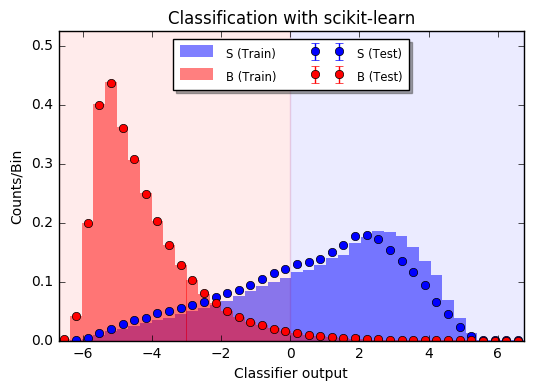

In [6]:
import matplotlib.pyplot as plt

X_sig_train = utils.preprocessing.get_training_sample(pd.DataFrame(X_sig))
X_bkg_train = utils.preprocessing.get_training_sample(pd.DataFrame(X_bkg))

X_sig_test = utils.preprocessing.get_test_sample(pd.DataFrame(X_sig))
X_bkg_test = utils.preprocessing.get_test_sample(pd.DataFrame(X_bkg))

Y_pred_sig_train = clf.decision_function(X_sig_train).ravel()
Y_pred_bkg_train = clf.decision_function(X_bkg_train).ravel()
Y_pred_sig_test = clf.decision_function(X_sig_test).ravel()
Y_pred_bkg_test = clf.decision_function(X_bkg_test).ravel()

utils.plotting.plot_classifier_output(clf,X_sig_train,X_bkg_train,X_sig_test,X_bkg_test)

plt.show()

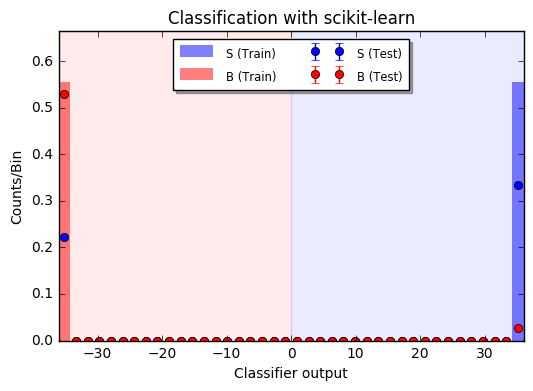

In [7]:
from sklearn.tree import DecisionTreeClassifier
clf =  ensemble.AdaBoostClassifier(DecisionTreeClassifier(),
                         n_estimators=100)
clf.fit(X_total_train,y_total_train)
X_sig_train = utils.preprocessing.get_training_sample(pd.DataFrame(X_sig))
X_bkg_train = utils.preprocessing.get_training_sample(pd.DataFrame(X_bkg))

X_sig_test = utils.preprocessing.get_test_sample(pd.DataFrame(X_sig))
X_bkg_test = utils.preprocessing.get_test_sample(pd.DataFrame(X_bkg))

Y_pred_sig_train = clf.decision_function(X_sig_train).ravel()
Y_pred_bkg_train = clf.decision_function(X_bkg_train).ravel()
Y_pred_sig_test = clf.decision_function(X_sig_test).ravel()
Y_pred_bkg_test = clf.decision_function(X_bkg_test).ravel()

utils.plotting.plot_classifier_output(clf,X_sig_train,X_bkg_train,X_sig_test,X_bkg_test)

plt.show()

In [ ]:
print Y_pred_sig_train
print Y_pred_bkg_train
print Y_pred_sig_test

In [ ]:
from sklearn.svm import SVC
clf =  SVC(C = 1.0, kernel = 'rbf',tol=0.01,gamma=0.005, verbose=1) 
clf.fit(X_total_train,y_total_train)
X_sig_train = utils.preprocessing.get_training_sample(pd.DataFrame(X_sig))
X_bkg_train = utils.preprocessing.get_training_sample(pd.DataFrame(X_bkg))

X_sig_test = utils.preprocessing.get_test_sample(pd.DataFrame(X_sig))
X_bkg_test = utils.preprocessing.get_test_sample(pd.DataFrame(X_bkg))

Y_pred_sig_train = clf.decision_function(X_sig_train).ravel()
Y_pred_bkg_train = clf.decision_function(X_bkg_train).ravel()
Y_pred_sig_test = clf.decision_function(X_sig_test).ravel()
Y_pred_bkg_test = clf.decision_function(X_bkg_test).ravel()

utils.plotting.plot_classifier_output(clf,X_sig_train,X_bkg_train,X_sig_test,X_bkg_test)

plt.show()